# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def extract_color_features(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    h, s, v = cv2.split(hsv)

    features = [
        np.mean(h), np.std(h),
        np.mean(s), np.std(s),
        np.mean(v), np.std(v)
    ]

    return np.array(features, dtype=np.float32)


In [ ]:
def extract_shape_features(img_gray):
    edges = cv2.Canny(img_gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return np.zeros(6, dtype=np.float32)

    cnt = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h > 0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

    image_area = img_gray.shape[0] * img_gray.shape[1]
    area_ratio = area / image_area

    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments).flatten()
    epsilon = 1e-12
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + epsilon)
    phi1, phi2 = hu_log[0], hu_log[1]

    return np.array([
        area_ratio,
        aspect_ratio,
        solidity,
        circularity,
        phi1,
        phi2
    ], dtype=np.float32)


In [ ]:
def compute_lbp(img_gray):
    h, w = img_gray.shape
    lbp = np.zeros((h-2, w-2), dtype=np.uint8)

    for i in range(1, h-1):
        for j in range(1, w-1):
            center = img_gray[i, j]
            binary = 0

            binary |= (img_gray[i-1, j-1] >= center) << 7
            binary |= (img_gray[i-1, j  ] >= center) << 6
            binary |= (img_gray[i-1, j+1] >= center) << 5
            binary |= (img_gray[i,   j+1] >= center) << 4
            binary |= (img_gray[i+1, j+1] >= center) << 3
            binary |= (img_gray[i+1, j  ] >= center) << 2
            binary |= (img_gray[i+1, j-1] >= center) << 1
            binary |= (img_gray[i,   j-1] >= center) << 0

            lbp[i-1, j-1] = binary

    return lbp


In [ ]:
class FruitsDataLoader:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.label_names = []

        self._prepare_dataset()

    def _prepare_dataset(self):
        for label_id, folder in enumerate(sorted(os.listdir(self.root_dir))):
            folder_path = os.path.join(self.root_dir, folder)

            if not os.path.isdir(folder_path):
                continue

            for file in os.listdir(folder_path):
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.image_paths.append(os.path.join(folder_path, file))
                    self.labels.append(label_id)
                    self.label_names.append(folder)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        color_features = extract_color_features(img_rgb)
        shape_features = extract_shape_features(img_gray)

        features = np.concatenate([color_features, shape_features])

        lbp_img = compute_lbp(img_gray)
        canny_img = cv2.Canny(img_gray, 100, 200)

        return {
            "img": img_rgb,
            "features": features,
            "lbp": lbp_img,
            "canny": canny_img,
            "label": self.labels[idx],
            "label_name": self.label_names[idx]
        }


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")
print("Kagglehub path:", path)
print("Contents of path:", os.listdir(path))

Using Colab cache for faster access to the 'fruits' dataset.
Kagglehub path: /kaggle/input/fruits
Contents of path: ['fruits-360_100x100', 'fruits-360_3-body-problem', 'fruits-360_dataset_meta', 'fruits-360_original-size', 'fruits-360_multi']


Feature vector shape: (12,)
Label: Apple 10
Image features:  [ 1.2192900e+01  1.8495354e+01  9.8756897e+01  7.8171471e+01
  1.7753729e+02  6.0464172e+01  3.1500000e-03  5.6999999e-01
  8.1175109e-03  3.5880113e-03 -1.6894670e+00 -3.2633984e+00]


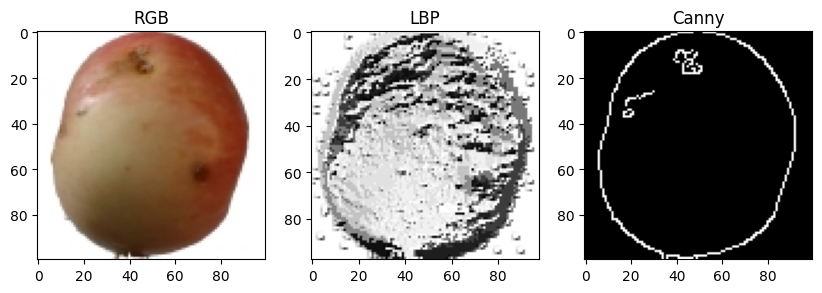

In [ ]:
dataset = FruitsDataLoader(path + "/fruits-360_100x100/fruits-360/Training")

sample = dataset[0]

print("Feature vector shape:", sample["features"].shape)
print("Label:", sample["label_name"])
print("Image features: ", sample["features"])

plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.imshow(sample["img"])
plt.title("RGB")

plt.subplot(1,3,2)
plt.imshow(sample["lbp"], cmap="gray")
plt.title("LBP")

plt.subplot(1,3,3)
plt.imshow(sample["canny"], cmap="gray")
plt.title("Canny")
plt.show()
